# Tutorial for Stacked Trapezoid model

This tutorial shows how to do simulations for stacked trapezoid model and how to fit the experimental data using this model.

In [1]:
from cdsaxs.simulations.stacked_trapezoid import StackedTrapezoidSimulation
import numpy as np

### Simulation

#### Prepare the data

In [2]:
pitch = 100 #nm distance between two lines
qzs = np.linspace(-0.5, 0.5, 121)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

#parameters
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
y1 = 0.
height = 20. #same as [20., 20.]
bot_cd = 40.
swa = [80., 80.0]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

#simulation data
i_params = {'heights': height,
            'langles': langle,
            'rangles': rangle,
            'y_start': y1,
            'bot_cd': bot_cd,
            'dwx': dwx,
            'dwz': dwz,
            'i0': i0,
            'bkg_cste': bkg,
            }

### Description of the parameters:

dwx, dwz, i0 and bkg are the parameters necessary to calculate the Debye-waller factor which accounts for the real world imperfections in the model. You can read more about it [here](https://en.wikipedia.org/wiki/Debye%E2%80%93Waller_factor).

The other parameters are the geometrical parameters of the model. The parameters are as follows:

*y_start* - starting y-coordinate of the base of the nano structure

*bot_cd* - bottom width (CD for critical dimension) of the nano structure

*heights* - height of each individual trapezoid can be a single value or a list of values 
in case of list of values, each value corresponds to the height of each individual trapezoid.

*langles* - list of all the left bottom angles of each individual trapezoid. The dictionary which is passed should have it in radians.

*rangles* - list of all the right bottom angles of each individual trapezoid. The dictionary which is passed should have it in radians.

*weight* - weight of each individual trapezoid to account for the fact that they could be made of different materials. here we will assume that all the trapezoids are made of the same material hence the weight is not necessary.

Note: In symmetric case either left or right angle can be passed and the other will be calculated using the symmetry.


So we are constructing a line space pattern and the cross section of each line looks like following:

![double trapezoid](../assets/images/double_stack.png)







#### Create instance of the Simulation class and call `simulate_diffraction` method

Text(0.5, 1.0, 'Stacked Trapezoid diffraction simulation')

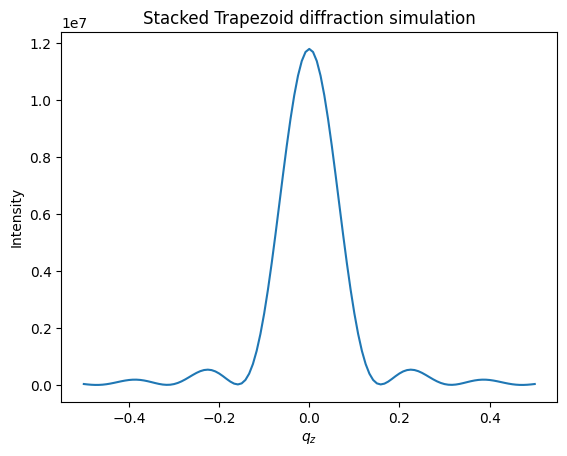

In [3]:
Simulation1 = StackedTrapezoidSimulation(qys=qxs, qzs=qzs)

intensity = Simulation1.simulate_diffraction(params=i_params)

#plot
import matplotlib.pyplot as plt
plt.plot(qzs, intensity)
plt.xlabel(r'$q_{z}$')
plt.ylabel('Intensity')
plt.title('Stacked Trapezoid diffraction simulation')

## Fitting

A txt or csv file with the experimental data containing the values for $Q_{x}$, $Q_{z}$ and intensities can be in the format as shown below:
    
    ```
    qx, qz, intensity
    0.1, 0.2, 0.3
    0.2, 0.3, 0.4
    0.3, 0.4, 0.5
    ...
    ```

for a text file you can read the data using the following code:

```python
import numpy as np
data = np.genfromtxt('path_to_file.txt', delimiter=',', skip_header=1)
qx = data[:,0]
qz = data[:,1]
intensity = data[:,2]
```

We will suppose that we've read the data and stored it in the variables qx, qz and intensity. And we'll use the simulated intensities used in the previous section.

Let's introduce a bit of noise to the simulated intensities to make it more realistic.

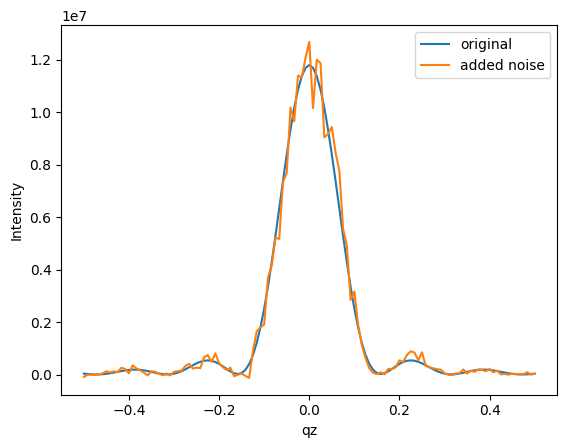

In [4]:
import matplotlib.pyplot as plt
intensity_noisy = intensity + np.sqrt(intensity) * np.random.normal(0, 300, intensity.shape)
plt.plot(qzs, intensity, label='original')
plt.plot(qzs, intensity_noisy, label='added noise')
plt.ylabel('Intensity')
plt.xlabel('qz')
plt.legend()

Now that we have our experimental data good to go for the fitting we need to provide a list of initial values and bounds for the parameters. The bounds are necessary to make sure that the fitting algorithm doesn't lose its way looking for impossible values. 

In [5]:
initial_params = {'heights': {'value': height+2, 'variation': 10E-2},
                    'langles': {'value': langle-0.2, 'variation': 10E-2},
                    'rangles': {'value': rangle-0.50, 'variation': 10E-1},
                    'y_start': {'value': y1+1, 'variation': 10E-1},
                    'bot_cd': {'value': bot_cd-1, 'variation': 10E-2},
                    'dwx': {'value': dwx, 'variation': 10E-5},
                    'dwz': {'value': dwz, 'variation': 10E-5},
                    'i0': {'value': i0, 'variation': 10E-5},
                    'bkg_cste': {'value': bkg, 'variation': 10E-5}
                    }

Create an instance of the Simulation class and pass it to the Fitter class along with data to fit

In [6]:
from cdsaxs.fitter import Fitter
Simulation2 = StackedTrapezoidSimulation(use_gpu=False, qys=qxs, qzs=qzs, initial_guess=initial_params)

Fitter1 = Fitter(Simulation=Simulation2, exp_data=intensity)

Then we'll call the `cmaes` method of the Fitter class to fit the data. It's important to know that this method provides a normalized set of values between -sigma and sigma and it is rescaled to the parameter values according to the model used.

*sigma* - the standard deviation of the values generated by the `cmaes` method

*ngen* - the number of generations to run the algorithm

*popsize* - the population size

*mu* - the number of parents to select for the next generation

*n_default* - the number parameters to fit

*restarts* - the number of times to restart the algorithm

*tolhistfun* - the tolerance for the history of the function value

*ftarget* - the target fitness value

*restart_from_best* - whether to restart from the best solution found so far

*verbose* - whether to print the progress of the algorithm

*dir_save* - the directory to save the results of the fitting

In [7]:
bestfit, fitness = Fitter1.cmaes(sigma=1, ngen=200, popsize=5000, mu=10, n_default=11, restarts=10, tolhistfun=10E-5, ftarget=10, restart_from_best=True, verbose=False)
print(bestfit)

     height1   langle1  langle2   rangle1   rangle2   y_start     bot_cd  \
0  20.205475  1.478093  1.37727  1.522585  1.246737  1.367989  38.193417   

        dwx       dwz        i0  bkg_cste  
0  0.100238  0.099777  9.999849  0.100187  


Now we have the bestfit parameters in the form of a pandas dataframe. We will look at the statistical information generated by the `mcmc_bestfit_stats` method.

In [8]:
stats = Fitter1.mcmc_bestfit_stats(N=11, sigma = 10., nsteps=200, nwalkers=5000)

print(stats)

11 parameters


100%|██████████| 200/200 [00:34<00:00,  5.80it/s]
/nobackup/nd276333/emcee_env/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


               mean       std   count        min        max   lower_ci  \
height1   20.159575  0.482159  182236  15.432713  29.090797  20.156665   
langle1    1.553179  0.358776  182236   0.000398   3.140211   1.551014   
langle2    1.424018  0.362339  182236   0.000603   3.135884   1.421831   
rangle1    1.584881  0.372932  182236   0.000275   3.140826   1.582631   
rangle2    1.491812  0.425218  182236   0.000091   3.141031   1.489246   
y_start    6.528696  3.567514  182236   0.006190  51.869177   6.507168   
bot_cd    38.220523  0.498972  182236  34.784194  41.622339  38.217512   
dwx        0.100299  0.000477  182236   0.096231   0.104155   0.100296   
dwz        0.099822  0.000539  182236   0.096082   0.109086   0.099819   
i0         9.999881  0.000489  182236   9.995369  10.004634   9.999878   
bkg_cste   0.100112  0.000516  182236   0.092231   0.105663   0.100109   

           upper_ci  uncertainity  
height1   20.162484      0.002910  
langle1    1.555344      0.002165  
lan